

# <font size="+3"><span style='color:#2994ff'> **P7 - Implémentez un modèle de scoring** </span></font>


<a id='LOADING_LIBRARIES'></a>

---

---

<font size="+1"> **LOADING THE LIBRARIES** </font>

---

In [12]:

# ----------------
# Packages Update
# ----------------
# !pip install --upgrade pip
# !pip install xgboost
# !pip install pycodestyle
# !pip install flake8 pycodestyle_magic

# General libraries
import sys
import os
import glob
import pandas as pd
import numpy as np
import csv
import time
from datetime import datetime
import pickle
import gc

from xgboost import XGBRegressor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

import tools_dataframe
import tools_preprocessing
import tools_feat_engineering



# Data visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns



# Validation code PEP8
# %load_ext pycodestyle_magic
# %pycodestyle_on

# Warnings
# import warnings
# from warnings import simplefilter
# warnings.filterwarnings(action='once')
# simplefilter(action='ignore', category=FutureWarning)
# simplefilter(action='ignore', category=ValueError)
# simplefilter(action='ignore', category=UserWarning)

# Versions
print('Version of used libraries :')

print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Dataframe tools      : ' + tools_dataframe.__version__)
now = datetime.now().isoformat()
print('Launched on : ' + now)

Version of used libraries :
Python                : 3.9.13 (main, Aug 25 2022, 23:26:10) 
[GCC 11.2.0]
NumPy                 : 1.23.5
Pandas                : 1.5.3
Dataframe tools      : 0.0.0
Launched on : 2023-07-05T12:42:37.143564



<a id='USED_PARAMETERS'></a>


<br>


---
---

<font size="+1"> **PARAMETERS USED IN THIS NOTEBOOK** </font>

---


In [13]:
# Parameters used in this notebook

seed = 84

palette4 = ["#253d85", "#618576", "#cba87d", "#faec4d"]

palette5 = ["#253d85", "#618576", "#9595b1", "#cba87d", "#faec4d"]

palette6 = ["#253d85", "#618576", "#9595b1", "#cba87d", "#dcd2a3", "#faec4d"]

In [14]:
dico_pd_option = {
    'display.max_rows': 400,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for key, value in dico_pd_option.items():
    pd.set_option(key, value)

In [15]:
# Define the folder containing the files with the project data
P7_source = "/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/p7_source"

os.chdir(P7_source)


<a id='USED_FUNCTIONS'></a>


<br>


---
---

<font size="+1"> **FUNCTIONS USED IN THIS NOTEBOOK** </font>

---



<font size="+3"><span style='color:#2994ff'> **P7 - Implémentez un modèle de scoring** </span></font>


<center><img src="./img/logo_projet.png" style="height: 250px;"/></center>

**Prêt à dépenser** wants to implement a **credit scoring tool to calculate the probability of a customer repaying their loan**, and then **classify the application as either granted or refused credit**. It therefore wants to develop a classification algorithm based on a variety of data sources (behavioural data, data from other financial institutions, etc.).

This notebook includes the **pre-processing** of data sets and the **feature engineering**:


- application_train/set.csv,

- office.csv**,

- office_balance.csv**,

- credit_card_balance.csv**,

- installments_payments.csv**,

- POS_CASH_balance.csv**,

- previous_application.csv


In particular:


- Cleaning** :

    - memory optimisation** by changing the data type. 

    - correction of **outliers**
    
    - correction of duplicated data

    - imputation** of missing values

- Feature engineering**: in this section, we will start by using the knowledge and insights gained from exploratory data analysis to obtain good sets of variables using feature engineering. Note that most of the variables generated are based on domain knowledge and experimentation. Without good sets of variables, machine learning algorithms cannot produce effective results. We will therefore have to find ingenious ways of doing feature engineering so that the model makes better decisions. 

- Aggregation**: with main data from Home Crédit Group.


***

Sources

***

The aggregation functions have been taken from the notebook: [Source](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering/output) by adapting the signature to pass the prefix of the column names and to be able to pass a dictionary of the statistics you want to add.


## <font color = '#0085dd'>**Table of content**</font>


[Librairies loading](#LOADING_LIBRARIES)<br>

[Functions used in this notebook](#USED_FUNCTIONS)<br>

---

[**Datasets**](#datasets)
 * [Description](#datasets_description)
   * [orders_dataset](#orders_dataset)
   * [customers_dataset](#customers_dataset)
   * [order_items](#order_items)
   * [products_dataset](#products_dataset)
   * [product_category_name_translation](#product_category_name_translation)   
   * [sellers_dataset](#sellers_dataset)
   * [order_payments](#order_payments)
   * [order_reviews](#order_reviews)
   * [geolocation_dataset](#geolocation_dataset)<br> 
<br>
 * [Columns preparation](#columns_preparation)
   * [Zip codes centroids calculation](#centroid_zipCode)
   * [Product category check and update](#cat_products)   
   
   
[**Datasets joining**](#datasets_joining)
 * [Data description](#data_description)
 * [Evaluation of missing values](#missing_values)  
 * [Column filling analysis](#column_fill)   
 * [Row filling analysis](#row_filling)  
 * [Features pre-selection](#features_preSelection)

[**Features engineering**](#features_engineering)
 * [Customers spatial distribution](#customers_spatial_distribution)
 * [RFM features](#RFM_features)  
 * [Products](#products)   
 * [Orders](#Orders)  
 * [Dates](#dates)
 * [Joining customers information](#join_customers_datasets)
 * [Features analysis](#features_analysis)  

[**Dataset for segmentation**](#segmentation_dataset)
<br>

---


<a id='feature_selection'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Feature selection** </span></span>


In this section, we will try to reduce the number of features, in such a way that it doesn't have a negative impact on the performance of the model.

In [16]:
# Load de datasets after feature engineering
path_train_dataset_after_feat_eng =  '../P7_scoring_credit/preprocessing/final_train_data.pkl'

with open(path_train_dataset_after_feat_eng, 'rb') as f:
    final_train_data = pickle.load(f)

In [17]:
# Load de datasets after feature engineering
path_test_dataset_after_feat_eng =  '../P7_scoring_credit/preprocessing/final_test_data.pkl'

with open(path_test_dataset_after_feat_eng, 'rb') as f:
    final_test_data = pickle.load(f)

In [18]:
#extracting the SK_ID_CURR from training and test data
skid_train = final_train_data['SK_ID_CURR']
skid_test = final_test_data['SK_ID_CURR']

#extracting the class labels for training data
target_train = final_train_data['TARGET']

In [19]:
# Create a copy of dataframes
train_data = final_train_data.copy()
test_data = final_test_data.copy()

# Dataframes alignement
train_data, test_data = train_data.align(test_data,
                                                  join='inner', axis=1)

# Suppression des identifiants
train_data = train_data.drop(columns=['SK_ID_CURR'])
test_data = test_data.drop(columns=['SK_ID_CURR'])

print(f'train_data : {train_data.shape}')
print(f'test_data : {test_data.shape}')

train_data : (307511, 634)
test_data : (48744, 634)


<a id='empty_feat'></a>

## <span style='background:#0085dd'><span style='color:white'>Looking for empty features</span></span>

In [20]:
print(f"Initial size of train_data {train_data.shape}")
print(f"\nInitial size of test_data {test_data.shape}")

Initial size of train_data (307511, 634)

Initial size of test_data (48744, 634)


Here, empty features refer to those features which have just one unique value. These features are useless for the classifiers, as they do not contain any information.

In [21]:
empty_columns = []
for col in train_data.columns:
    if len(train_data[col].unique()) <=1:
        empty_columns.append(col)
    
print(f"There are {len(empty_columns)} columns with just 1 unique value")
print("Removing these from dataset")
train_data = train_data.drop(empty_columns, axis = 1)
test_data = test_data.drop(empty_columns, axis = 1)

There are 45 columns with just 1 unique value
Removing these from dataset


<a id='feat_select_LGBM'></a>

## <span style='background:#0085dd'><span style='color:white'>Recursive Feature Selection using LightGBM</span></span>

In this section, we will further try to reduce the feature set, using a Classification Model, using the feature importance attribute
. 
In this method, we will recursively run the Classification model on training dataset, and will check the Cross Validation AUC. If the Cross-Validation AUC goes below a certain threshold, we will stop adding the features the features.

The steps would be:
1. Run the Classifier on whole training set, and calculate 3 fold cross-validation AUC.
2. Select the features which have non-zero feature importance as per the model.
3. Rerun the Classifier with the features which had zero feature importance. This is done because there might be cases where the classifier would have assigned 0-feature imporatnce to some features but that could be due to just that iteration and randomness. So we rerun the classifier on those features, to see if they alone can give good metric score.
4. Stop adding features if the Cross Validation score for low importance features goes below a threshold.

**Modélisation**

***Premier passage***

In [22]:
# Initialiser un tableau vide pour contenir les features importance
feature_importances = np.zeros(train_data.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='goss',
                           n_estimators=10000,
                           class_weight='balanced')

In [24]:
# Entraînement du modèle deux fois pour éviter l'overfitting
for i in range(2):

    # Split en jeux d'entraînement et de validation
    train_features, valid_features, train_y, valid_y = \
        train_test_split(train_data, target_train,
                         test_size=0.25, random_state=i)

    # Entraînement en utilisant early stopping
    model.fit(train_features, train_y,
              early_stopping_rounds=100,
              eval_set=[(valid_features, valid_y)],
              eval_metric='auc', verbose=200)

    # Sauvegarde des features importances
    feature_importances += model.feature_importances_

/home/raquelsp/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/raquelsp/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.800853	valid_0's binary_logloss: 0.49067


/home/raquelsp/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/raquelsp/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.802051	valid_0's binary_logloss: 0.489485


In [25]:
# Assurez-vous de faire la moyenne des features importance !
# puisque le modèle a été entraîné 2 fois
feature_importances = feature_importances / 2
df_fs_lightgbm = \
    pd.DataFrame({'feature': list(train_data.columns),
                  'importance': feature_importances}) \
    .sort_values('importance', ascending=False)

df_fs_lightgbm.head()

,feature,importance
78,TARGET_NEIGHBORS_500_MEAN,147.0
192,REGIONS_RATING_INCOME_MUL_0,145.5
7,DAYS_BIRTH,70.0
70,EXT_SOURCE_MEAN,64.0
404,CNT_INSTALMENT_FUTURE_MIN_MEAN,56.0


In [26]:
# Exploration des variables avec zéro importance
# Find the features with zero importance
zero_features = \
    list(df_fs_lightgbm[df_fs_lightgbm['importance'] == 0.0]['feature'])
print(f'{len(zero_features)} variables avec 0.0 importance :\n')
zero_features

96 variables avec 0.0 importance :



['CONTRACT_Approved',
 'CREDIT_TYPE_Loan for business development_MEAN_OVERALL',
 'EXT_SOURCE_3_MIN_AGG_NAME_EDUCATION_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE',
 'CREDIT_TYPE_Interbank credit_MEAN_OVERALL',
 'AMT_INCOME_TOTAL_MIN_AGG_CODE_GENDER_FLAG_OWN_CAR_FLAG_OWN_REALTY',
 'CREDIT_TYPE_Cash loan (non-earmarked)_MEAN_OVERALL',
 'CREDIT_ACTIVE_Bad debt_MEAN_OVERALL',
 'EXT_SOURCE_2_MAX_AGG_CODE_GENDER_FLAG_OWN_CAR_FLAG_OWN_REALTY',
 'MAX_AMT_OVERDUE_DURATION_RATIO_MEAN_OVERALL',
 'CURRENCY_currency 4_MEAN_OVERALL',
 'FLAG_OVERDUE_RECENT_MEAN_OVERALL',
 'CURRENCY_currency 3_MEAN_OVERALL',
 'MIN_PAYMENT_TOTAL_RATIO_MIN_YEAR_REST',
 'CURRENCY_currency 1_MEAN_OVERALL',
 'DAYS_CREDIT_ENDDATE_MEAN_OVERALL',
 'CONTRACT_Demand',
 'DAYS_CREDIT_UPDATE_MEAN_OVERALL',
 'CREDIT_DURATION_MEAN_OVERALL',
 'EXT_SOURCE_3_MIN_AGG_CODE_GENDER_FLAG_OWN_CAR_FLAG_OWN_REALTY',
 'CONTRACT_XNA_MEAN',
 'CONTRACT_Refused',
 'FLAG_DOCUMENT_11',
 'BUREAU_AMT_CREDIT_SUM_OVERDUE_MAXCREDIT_ACTIVE_REST_INCOME_RATIO',
 

In [27]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    Source : 
    https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 12))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:30]))), 
            df['importance_normalized'].head(30), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:30]))))
    ax.set_yticklabels(df['feature'].head(30))
    
    # Plot labeling
    plt.xlabel('Importance normalisée'); plt.title('Features Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Nombre de variables'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d variables nécessaires pour %0.2f de cumulative importance' % (importance_index + 1, threshold))
    
    return df

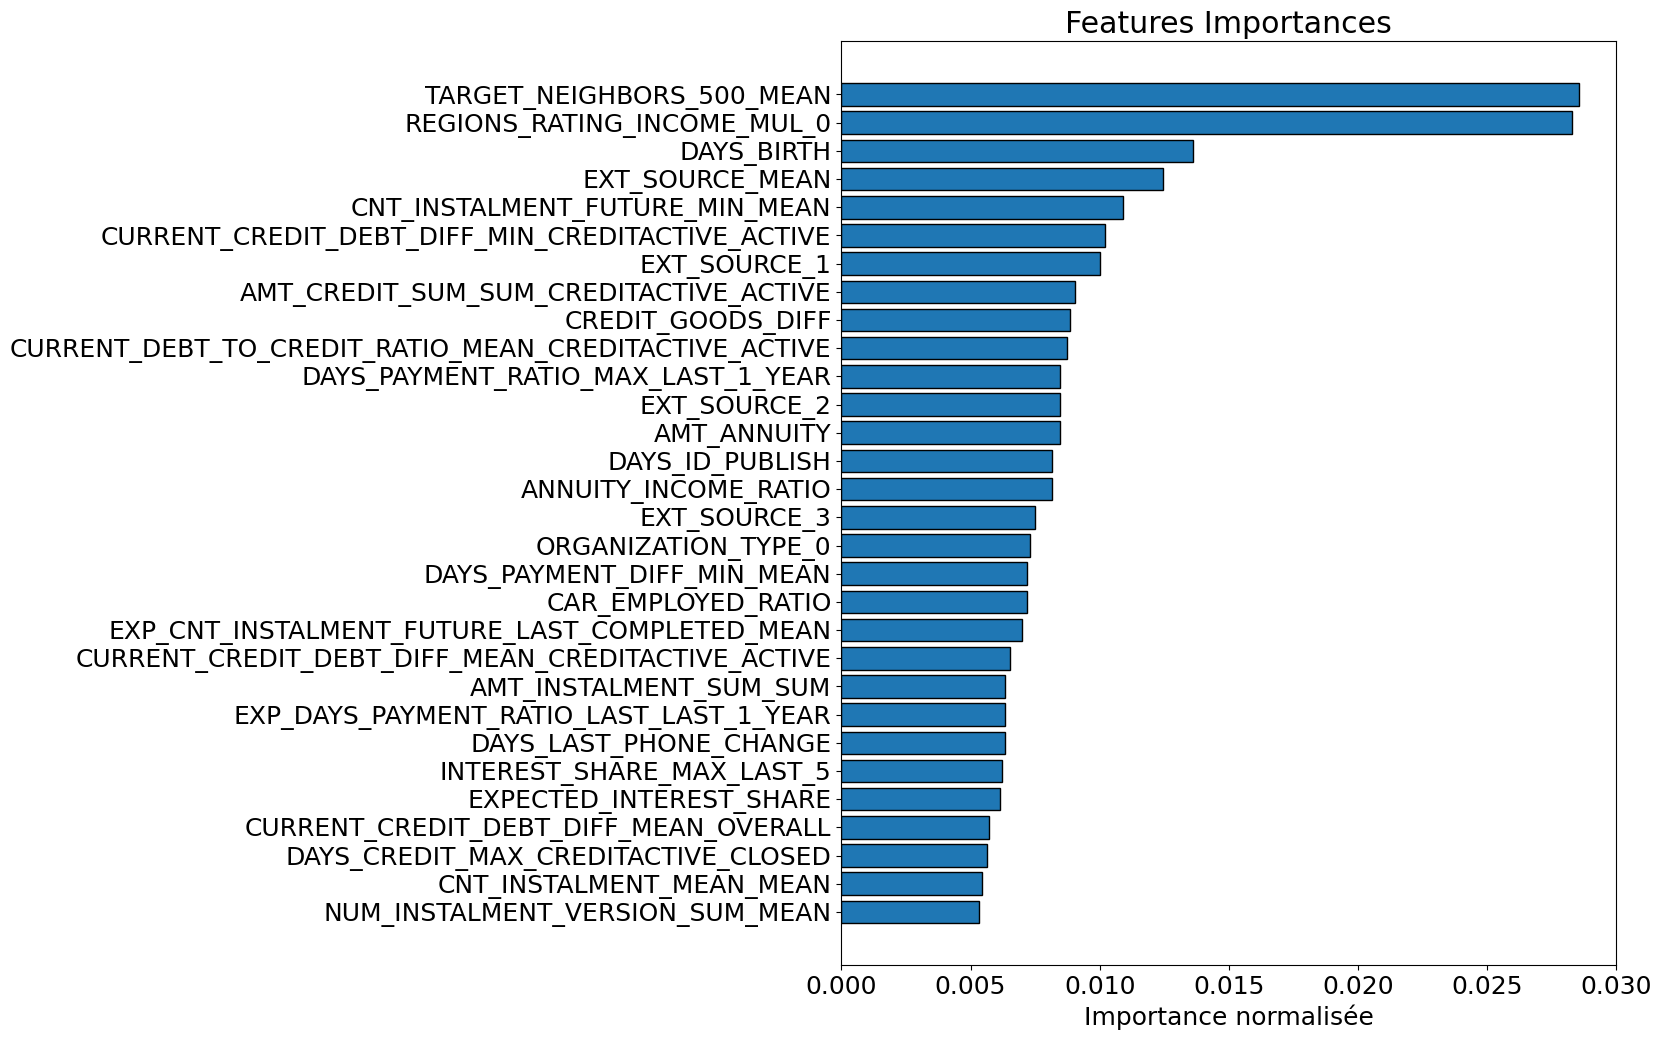

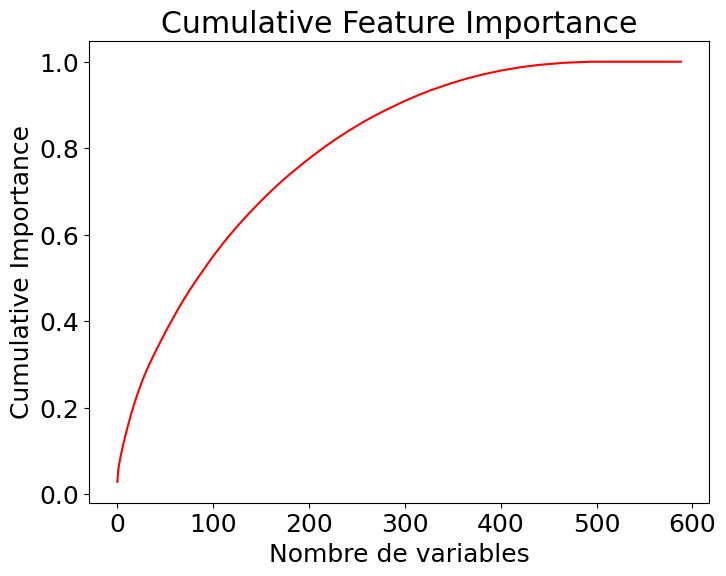

293 variables nécessaires pour 0.90 de cumulative importance


In [28]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm = plot_feature_importances(df_fs_lightgbm)

In [29]:
# Suppression des variables avec zéro importance
train_data = train_data.drop(columns=zero_features)
test_data = test_data.drop(columns=zero_features)

print(f'train_data : {train_data.shape}')
print(f'test_data : {test_data.shape}')

train_data : (307511, 493)
test_data : (48744, 493)


***Second passage***

In [30]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances


In [31]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_2, df_fs_lightgbm_2 = identify_zero_importance_features(train_data,
                                       target_train)

/home/raquelsp/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/raquelsp/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.800857	valid_0's binary_logloss: 0.490721


/home/raquelsp/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/raquelsp/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.801966	valid_0's binary_logloss: 0.489916

There are 8 features with 0.0 importance


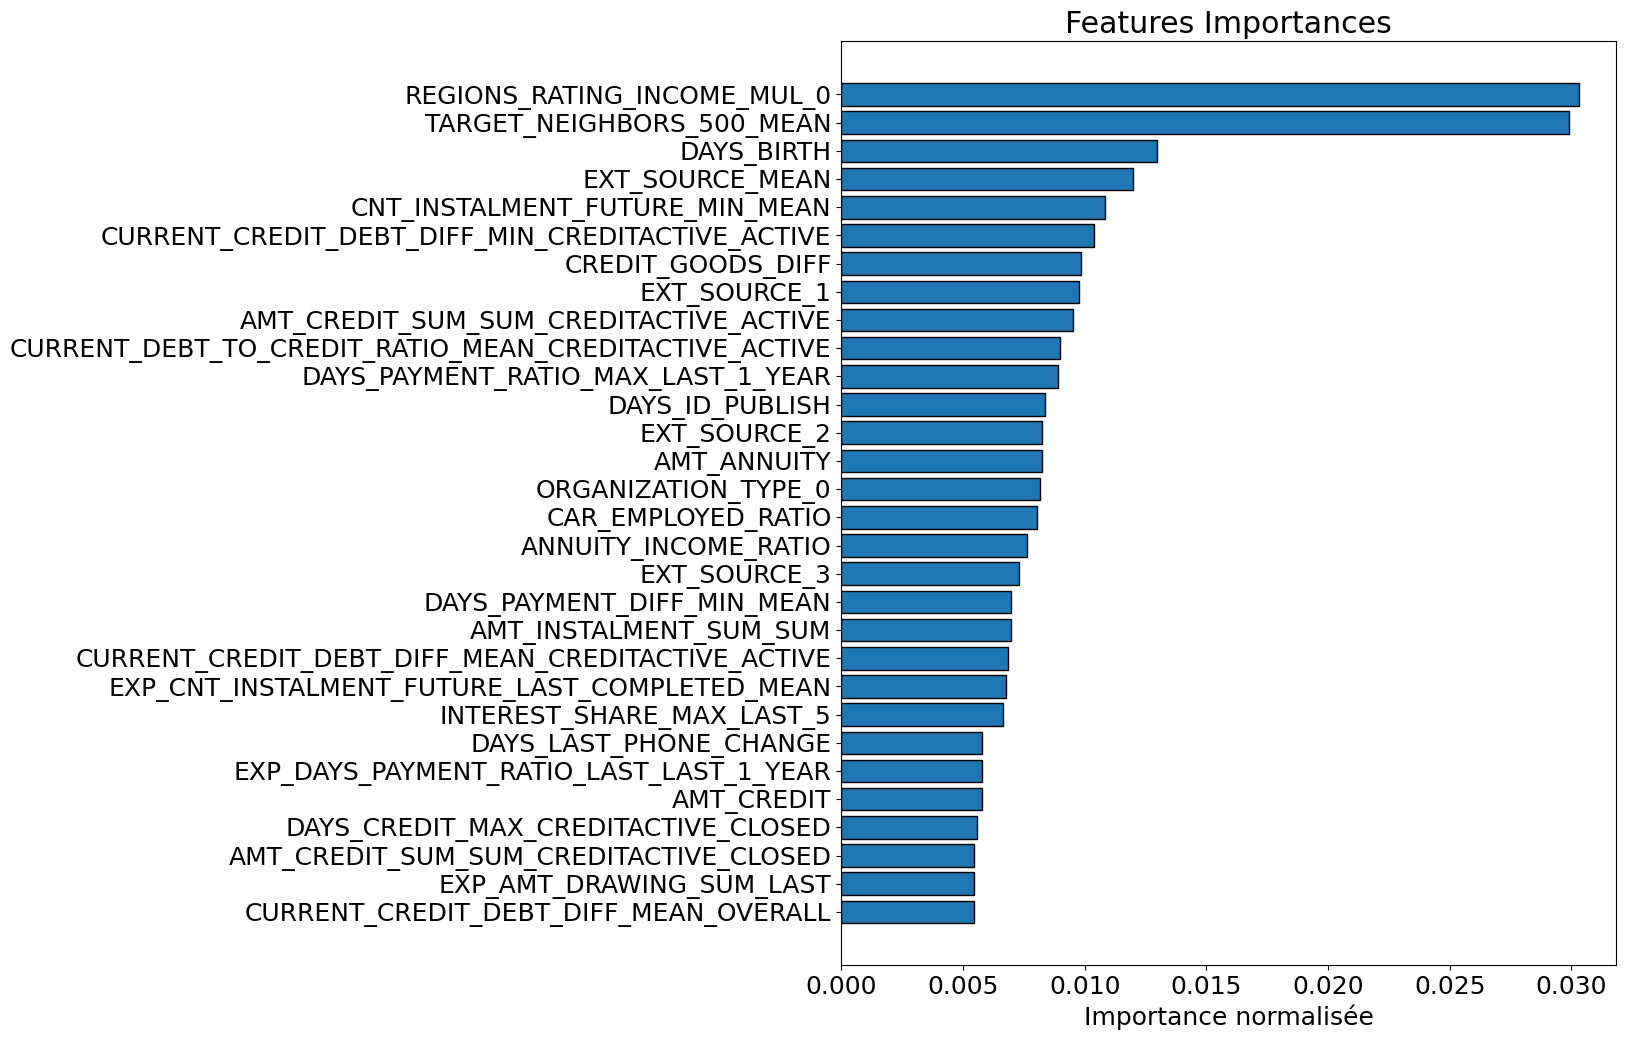

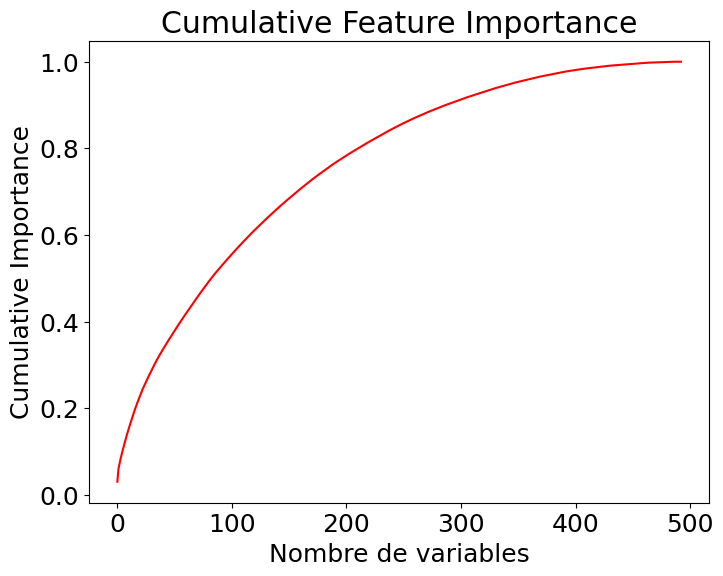

288 variables nécessaires pour 0.90 de cumulative importance


In [32]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm_2 = plot_feature_importances(df_fs_lightgbm_2)

In [33]:
# Suppression des variables avec zéro importance
train_data = train_data.drop(columns=zero_features_2)
test_data = test_data.drop(columns=zero_features_2)

print(f'train_data : {train_data.shape}')
print(f'test_data : {test_data.shape}')

train_data : (307511, 485)
test_data : (48744, 485)


In [34]:
#standardizing the data
scaler = StandardScaler()
x_train_std = scaler.fit_transform(train_data)
x_test_std = scaler.fit_transform(test_data)
y_train = target_train

#replacing nan values with 0
x_train_std[np.isnan(x_train_std)] = 0
x_test_std[np.isnan(x_test_std)] = 0

**Reconstitution des dataframes**

In [36]:
train_data['TARGET'] = target_train
train_data['SK_ID_CURR'] = skid_train
print(f'train_data : {train_data.shape}')
test_data['SK_ID_CURR'] = skid_test
print(f'test_data : {test_data.shape}')

train_data : (307511, 487)
test_data : (48744, 486)


# ends